In [2]:
from stable_baselines3 import PPO

import gymnasium as gym
import gym_unbalanced_disk, time
from gym_unbalanced_disk import UnbalancedDisk
from gymnasium import spaces
import gymnasium.wrappers, gymnasium.envs.classic_control

import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import torch

In [3]:
class my_gym(UnbalancedDisk):
    def __init__(self, dt = 0.025, umax = 3, target = np.pi, nvec=10):
        self.target = target
        self.nvec = nvec
        self.umax = umax

        super(my_gym,self).__init__(umax=umax, dt=dt)

        # Discretize the action space into nvec values between -umax and +umax
        self.actions = np.linspace(-umax, umax, nvec)
        self.action_space = spaces.Discrete(nvec)  # Discrete action space

        # Observation space: angle and angular velocity
        self.observation_space = spaces.Box(
            low=np.array([-np.pi, -40], dtype=np.float32),
            high=np.array([np.pi, 40], dtype=np.float32),
            shape=(2,),
        )

    def step(self, action_idx):
        # Convert discrete action index to actual control input
        u = self.actions[action_idx]
        return super().step(u) 
    
    # This ensures compatibility with gym.wrappers.TimeLimit, which calls env.reset(seed=..., options=...) internally.
    # The custom environment (UnbalancedDisk) does not follow the Gymnasium API, specifically the new signature of the reset() method.
    def reset(self, seed=None, options=None):
        if seed is not None:
            super().reset(seed=seed)
            self.np_random, _ = gym.utils.seeding.np_random(seed)
        
        # Reset my environment's state
        obs = super().reset()
        if isinstance(obs, tuple) and len(obs) == 2:
            obs = obs[0]
        # Return observation and empty info dict as expected by Gymnasium
        return obs, {}
    
def make_radial_basis_network(env,nvec,scale):
    # env: is the given enviroment
    # nvec: is the given number of grid points in each dimention.
    # scale: is the sigma_c in the equation
    if isinstance(nvec,int):
        nvec = [nvec]*env.observation_space.shape[0]
    
    # This creates a grid of points c_i the lower bound to the upper bound with nvec number of samples in each dimention
    low, high = env.observation_space.low, env.observation_space.high # get upper and lower bound
    assert np.all(np.isfinite(low)) and np.all(np.isfinite(high)), f'infinite bounds on obersvation space are not permitted low={low}, high={high}'
    Xvec = [np.linspace(l,h,num=ni) for l,h,ni in zip(low,high,nvec)] # calculate the linspace in all directions
    c_points = np.array(np.meshgrid(*Xvec)) # meshgrid all the linspaces together (Nx, X1, X2, X3, ...) 
    c_points = np.moveaxis(c_points, 0, -1) #transform to (X1, X2, X3, ..., Nobs) 
    c_points = c_points.reshape((-1,c_points.shape[-1])) #flatten into the size (Nc, Nobs)
    dx = np.array([X[1]-X[0] for X in Xvec]) # spacing (related to the B matrix)
    
    def basis_fun(obs):
        #this function should return the vector containing all phi_i of all c_points
        obs = np.array(obs) #(Nobs)
        
        dis = (c_points-obs[None,:])/dx[None,:] #dim = (Nbasis, Nobs)
        exp_arg = np.sum(dis**2,axis=1)/(2*scale**2) #squared distance to every point
        Z = -exp_arg+np.min(exp_arg) # for numerical stability you can add the minimum.
        R = np.exp(Z)
        return R/np.sum(R)
    
    return basis_fun #returns a basis function


env = my_gym()
# for scale in reversed([0.05, 0.1, 0.2, 0.4, 0.5,1.0]):
#     f = make_radial_basis_network(env,nvec=100,scale=scale)
#     locations = np.linspace(0,1,num=500)
#     basis_val = np.array([f([a]) for a in locations])
#     plt.title(f'scale={scale}')
#     plt.plot(locations, basis_val)
#     plt.show()


Check discretization

In [4]:
print(env.action_space)

for __ in range(5):
    print(env.action_space.sample())

Discrete(10)
5
5
9
3
7


In [5]:


# env = gym.make("CartPole-v1", render_mode="human")
# env = gym_unbalanced_disk.UnbalancedDisk(dt=0.025, umax=3.)

# model = PPO("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=10_000)

# vec_env = model.get_env()
# obs = vec_env.reset()
# for i in range(1000):
#     action, _states = model.predict(obs, deterministic=True)
#     obs, reward, done, info = vec_env.step(action)
#     vec_env.render()
#     # VecEnv resets automatically
#     # if done:
#     #   obs = env.reset()

# env.close()


# import gymnasium as gym
# import gym_unbalanced_disk, time

# #env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3.) 
# env = gym_unbalanced_disk.UnbalancedDisk(dt=0.025, umax=3.) #alternative

# obs, info = env.reset()
# try:
#     for i in range(200):
#         obs, reward, terminated, truncated, info = env.step(env.action_space.sample()) #random action
#         print(obs, reward)
#         env.render()
#         time.sleep(1/24)
#         if terminated or truncated:
#             obs = env.reset()
# finally: #this will always run
#     env.close()

DQL as the notebook set 7

In [6]:
class Qfunction(nn.Module):
    def __init__(self, env):
        super(Qfunction, self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40)
        self.F1 = nn.Tanh()
        self.lay2 = nn.Linear(40, env.action_space.n)  # Outputs Q-values for each discrete action
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))  # (batch_size, n_actions)


Check action space

In [7]:
print(env.action_space)

Discrete(10)


Test Qfunction

In [8]:
Q = Qfunction(env)
#test validity:
obs, info = env.reset()
obs_tensor = torch.tensor(obs,dtype=torch.float32)[None,:] #convert to an torch tensor with size (1, Nobs=6)
print('obs_tensor = ', obs_tensor)
print('Q(x) = ',Q(obs_tensor)) #output #(1,Naction=3)

obs_tensor =  tensor([[0.0017, 0.0024]])
Q(x) =  tensor([[ 0.1866,  0.1889, -0.1552, -0.1488,  0.1643, -0.0174,  0.1802,  0.0174,
          0.5410,  0.1938]], grad_fn=<AddmmBackward0>)


## Evaluating Discretization Performance (under construction)

Use grid search over several nvec values and evaluate:

- Average Episode Return
- Learning Curve
- Policy Smoothness

In [9]:
def gridSearchDiscretization():
    nvec_list = [3, 5, 10, 15, 20]
    results = {}

    for nvec in nvec_list:
        env = my_gym(nvec=nvec)
        Q = Qfunction(env)
        # TODO: implement training loop (Q-learning, DQN, etc.)
        # Train for N episodes
        avg_reward = evaluate_policy(Q, env, episodes=100)  # Rollout with greedy policy
        results[nvec] = avg_reward

    plt.plot(results.keys(), results.values(), marker='o')
    plt.xlabel('nvec (number of discrete actions)')
    plt.ylabel('Average return over 100 episodes')
    plt.title('Effect of Discretization Resolution on Policy Performance')
    plt.grid(True)
    plt.show()
  

Visualize the $Q$-function

In [10]:
def show(Q,env):
    with torch.no_grad():
        #you can use Qfun(obs) as a shorthand for the q function.
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() #convert x to torch.tensor -> put in the Q function -> back to numpy
        try:
            obs, info = env.reset() #b)
            env.render() #b)
            time.sleep(1) #b)
            while True: #b)
                action = np.argmax(Qfun(obs)) #b)
                obs, reward, terminated, truncated, info = env.step(action) #b)
                time.sleep(1/60) #b)
                env.render() #b)
                if terminated or truncated: #b)
                    time.sleep(0.5)  #b)
                    break  #b)
        finally: #this will always run even when an error occurs
            env.close()

max_episode_steps = 250
env = gym.wrappers.TimeLimit(env,max_episode_steps=max_episode_steps) 
Q = Qfunction(env)
show(Q,env)

In [11]:
class SafeObsWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

    def observation(self, obs):
        obs = np.asarray(obs, dtype=np.float32).flatten()
        if obs.shape != (2,):
            raise ValueError(f"Malformed observation: {obs}")
        return obs

    def reset(self, **kwargs):
        result = self.env.reset(**kwargs)
        obs = result[0] if isinstance(result, tuple) else result
        return self.observation(obs), {}

In [12]:
env = my_gym()
env = SafeObsWrapper(env)  # Sanitize obs FIRST
env = gym.wrappers.TimeLimit(env, max_episode_steps=max_episode_steps)
Q = Qfunction(env)
show(Q,env)

rollout

In [17]:
def rollout(Q, env, epsilon=0.1, N_rollout=10_000): 
    #save the following (use .append)
    Start_state = [] #hold an array of (x_t)
    Actions = [] #hold an array of (u_t)
    Rewards = [] #hold an array of (r_{t+1})
    End_state = [] #hold an array of (x_{t+1})
    Terminal = [] #hold an array of (terminal_{t+1})
    # Qfun( a numpy array of the obs) -> a numpy array of Q values
    Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() 
    with torch.no_grad():
        
        # obs, info = env.reset() #c)
        result = env.reset()
        obs = result[0]
        # print(f"First result: {result}, type: {type(result)}")
        # print(f"First result[0]: {result[0]}, type: {type(result[0])}")
        # print(f"First obs: {obs}, type: {type(obs)}")
        for i in range(N_rollout): #c)
            if np.random.uniform()>epsilon: #c)
                Qnow = Qfun(obs) #c)
                action = np.argmax(Qnow) #c)
            else: #c)
                action = env.action_space.sample() #c)
            Start_state.append(obs) #c)
            Actions.append(action) #c)
            
            obs_next, reward, terminated, truncated, info = env.step(action) #c)

            Terminal.append(terminated) #c)
            Rewards.append(reward) #c)
            End_state.append(obs_next) #c)

            if terminated or truncated: #c)
                # obs, info = env.reset() #c)
                result = env.reset()
                obs = result[0]
                # print(f"Last obs: {obs}, type: {type(obs)}")
            else: #c)
                obs = obs_next #c)
                
    #error checking:
    assert len(Start_state)==len(Actions)==len(Rewards)==len(End_state)==len(Terminal), f'error in lengths: {len(Start_state)}=={len(Actions)}=={len(Rewards)}=={len(End_state)}=={len(Dones)}'
    return np.array(Start_state), np.array(Actions), np.array(Rewards), np.array(End_state), np.array(Terminal).astype(int)

max_episode_steps = 250

env = gym.wrappers.TimeLimit(env,max_episode_steps=max_episode_steps)
Q = Qfunction(env) 
Start_state, Actions, Rewards, End_state, Terminal = rollout(Q,env,N_rollout=300)
print(Start_state, Actions, Rewards, End_state, Terminal)

[[ 7.70046550e-04 -2.73473305e-03]
 [-2.53237486e-02 -1.90150082e+00]
 [-8.36237445e-02 -2.67970872e+00]
 [-1.68880746e-01 -4.13003635e+00]
 [-2.85334736e-01 -5.21602392e+00]
 [-4.24624115e-01 -5.87655497e+00]
 [-5.76749921e-01 -6.09397554e+00]
 [-7.14658797e-01 -4.98929691e+00]
 [-8.35517108e-01 -4.53829145e+00]
 [-9.39946115e-01 -3.86361766e+00]
 [-1.02598190e+00 -3.02920270e+00]
 [-1.08998191e+00 -2.09557509e+00]
 [-1.09288502e+00  1.90540385e+00]
 [-1.02204418e+00  3.76003909e+00]
 [-8.77393246e-01  7.68252850e+00]
 [-6.42361343e-01  1.10807028e+01]
 [-3.30615461e-01  1.36672821e+01]
 [ 3.46642546e-02  1.51535206e+01]
 [ 3.84918839e-01  1.26870518e+01]
 [ 6.97174251e-01  1.21128330e+01]
 [ 9.83524919e-01  1.08293886e+01]
 [ 1.23271132e+00  9.11117744e+00]
 [ 1.43741548e+00  7.20727491e+00]
 [ 1.59128082e+00  5.27969074e+00]
 [ 1.70120358e+00  3.42256880e+00]
 [ 1.76501095e+00  1.65970612e+00]
 [ 1.78696716e+00 -1.94155462e-02]
 [ 1.75139034e+00 -2.73657894e+00]
 [ 1.64685142e+00 -5

evaluation

In [14]:
def eval_Q(Q,env):
    with torch.no_grad():
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
        rewards_acc = 0 #d)
        obs, info = env.reset() #d)
        while True: #d)
            action = np.argmax(Qfun(obs)) #d)
            obs, reward, terminated, truncated, info = env.step(action) #d)
            rewards_acc += reward #d)
            if terminated or truncated: #d)
                return rewards_acc #d)


train

In [15]:


from copy import deepcopy
def DQN_rollout(Q, optimizer, env, gamma=0.98, use_target_net=False, N_iterations=21, N_rollout=20000, \
                N_epochs=10, batch_size=32, N_evals=10, target_net_update_feq=100):
    best = -float('inf')
    torch.save(Q.state_dict(),'Q-checkpoint')
    try:
        for iteration in range(N_iterations):
            epsilon = 1.0 - iteration/(N_iterations-1) #e=) 1.
            print(f'rollout iteration {iteration} with epsilon={epsilon:.2%}...')
            
            #2. rollout
            Start_state, Actions, Rewards, End_state, Terminal = rollout(Q, env, epsilon=epsilon, N_rollout=N_rollout) #e) 2.
            
            #Data conversion, no changes required
            convert = lambda x: [torch.tensor(xi,dtype=torch.float32) for xi in x]
            Start_state, Rewards, End_state, Terminal = convert([Start_state, Rewards, End_state, Terminal])
            Actions = Actions.astype(int)

            print('starting training on rollout information...')
            t = 0
            for epoch in range(N_epochs): 
                for i in range(batch_size,len(Start_state)+1,batch_size): 
                    if t%target_net_update_feq==0:
                        Qtarget = deepcopy(Q) #g)
                        pass
                    t += 1
                    
                    Start_state_batch, Actions_batch, Rewards_batch, End_state_batch, Terminal_batch = [d[i-batch_size:i] for d in \
                                                                                                        [Start_state, Actions, Rewards, End_state, Terminal]] #e=) 3.
                    
                    with torch.no_grad(): #3.
                        if use_target_net:
                            pass
                            maxQ = torch.max(Qtarget(End_state_batch),dim=1)[0] #g)
                        else:
                            maxQ = torch.max(Q(End_state_batch),dim=1)[0] #e=) 3.
                    
                    # action_index = np.stack((np.arange(batch_size),Actions_batch),axis=0)
                    # ids = np.arange(batch_size)
                    
                    Qnow = Q(Start_state_batch)
                    # print(f'{action_index.shape=}')
                    # print(f'{Qnow.shape=}')
                    Qnow = Qnow[np.arange(batch_size), Actions_batch] #Q(x_t,u_t) is given
                    # print(Rewards_batch.shape, maxQ.shape, Terminal_batch.shape, Qnow.shape)
                    Loss = torch.mean((Rewards_batch + gamma*maxQ*(1-Terminal_batch) - Qnow)**2) #e) 3.
                    optimizer.zero_grad() #e) 3.
                    Loss.backward() #e) 3.
                    optimizer.step() #e) 3.
                
                score = np.mean([eval_Q(Q,env) for i in range(N_evals)]) #e=) 3.
                
                print(f'iteration={iteration} epoch={epoch} Average Reward per episode:',score)
                if score>best:
                    best = score
                    print('################################# \n new best',best,'saving Q... \n#################################')
                    torch.save(Q.state_dict(),'Q-checkpoint')
            
            print('loading best result')
            Q.load_state_dict(torch.load('Q-checkpoint'))
    finally: #this will always run even when using the a KeyBoard Interrupt. 
        print('loading best result')
        Q.load_state_dict(torch.load('Q-checkpoint'))

In [18]:
gamma = 0.98 #f=)
batch_size = 32 #f=)
N_iterations = 21 #f=)
N_rollout = 20000 #f=)
N_epochs = 10 #f=)
N_evals = 5 #f=)
lr = 0.0005 #given

assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'
Q = Qfunction(env)
optimizer = torch.optim.Adam(Q.parameters(),lr=lr) #low learning rate
DQN_rollout(Q, optimizer, env, use_target_net=True, gamma=gamma, N_iterations=N_iterations, \
            N_rollout=N_rollout, N_epochs=N_epochs, N_evals=N_evals)

rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: 1.1948161105544792e-08
################################# 
 new best 1.1948161105544792e-08 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: 1.2118901612830677e-08
################################# 
 new best 1.2118901612830677e-08 saving Q... 
#################################
iteration=0 epoch=2 Average Reward per episode: 1.2088313671307146e-08
iteration=0 epoch=3 Average Reward per episode: 0.00016158917456508758
################################# 
 new best 0.00016158917456508758 saving Q... 
#################################
iteration=0 epoch=4 Average Reward per episode: 0.00020580357177534905
################################# 
 new best 0.00020580357177534905 saving Q... 
#################################
iteration=0 epoch=5 Average Reward per episode: 0.00033469054736273913
##########################

In [22]:
env_vis = my_gym()
env_vis = SafeObsWrapper(env_vis)  # Sanitize obs FIRST
env_vis = gym.wrappers.TimeLimit(env_vis, max_episode_steps=max_episode_steps)

show(Q,env_vis)

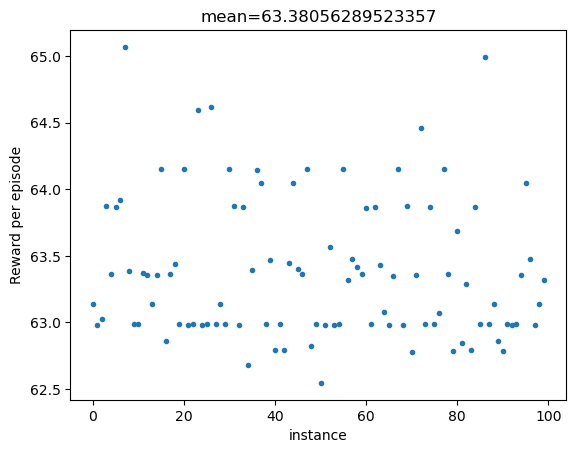

In [20]:
Rewards = [eval_Q(Q,env) for i in range(100)]
plt.plot(Rewards,'.')
plt.title(f'mean={np.mean(Rewards)}')
plt.xlabel('instance')
plt.ylabel('Reward per episode')
plt.show()